In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from torchvision.models import mobilenet_v2
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [3]:
# Custom dataset class to handle loading our data
class CalorieDataset(Dataset):
    def __init__(self, lunch_images, breakfast_images, nutrition_features, labels):
        # Convert data to tensors for PyTorch and format images (channels first for CNNs)
        self.lunch_images = torch.FloatTensor(lunch_images).permute(0, 3, 1, 2)  
        self.breakfast_images = torch.FloatTensor(breakfast_images).permute(0, 3, 1, 2)
        self.nutrition_features = torch.FloatTensor(nutrition_features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        # Just returns how many samples we have
        return len(self.labels)

    def __getitem__(self, idx):
        # fetch one sample at a time (images, features, label)
        return (
            self.lunch_images[idx],
            self.breakfast_images[idx],
            self.nutrition_features[idx],
            self.labels[idx]
        )

In [5]:
# The model that combines image features and nutrition data for calorie prediction
class CaloriePredictor(nn.Module):
    def __init__(self, nutrition_feature_size):
        super(CaloriePredictor, self).__init__()
        
        # Pre-trained MobileNetV2 for image feature extraction
        mobilenet_lunch = mobilenet_v2(pretrained=True)
        mobilenet_breakfast = mobilenet_v2(pretrained=True)

        # Freeze these pre-trained layers since we don't want to train them again
        for param in mobilenet_lunch.parameters():
            param.requires_grad = False
        for param in mobilenet_breakfast.parameters():
            param.requires_grad = False

        # Processing pipeline for lunch images
        self.lunch_feature_extractor = nn.Sequential(
            mobilenet_lunch.features,  # Features from MobileNet
            nn.AdaptiveAvgPool2d(1),  # Turns feature maps into single vector
            nn.Flatten(),
            nn.Linear(mobilenet_lunch.last_channel, 128),  # Reduce to 128 dimensions
            nn.ReLU(),
            nn.Dropout(0.5) 
        )

        # Processing pipeline for breakfast images (same logic as lunch images)
        self.breakfast_feature_extractor = nn.Sequential(
            mobilenet_breakfast.features,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(mobilenet_breakfast.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Layers to process the nutritional data
        self.nutrition_processor = nn.Sequential(
            nn.Linear(nutrition_feature_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),  # End up with a 32-dimensional output
            nn.ReLU()
        )

        # Combines all features and predicts lunch calories
        self.predictor = nn.Sequential(
            nn.Linear(128 * 2 + 32, 64),  # Combine image and nutrition features
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Single output for regression
        )

    def forward(self, lunch_img, breakfast_img, nutrition_features):
        # Extract features from both images
        lunch_features = self.lunch_feature_extractor(lunch_img)
        breakfast_features = self.breakfast_feature_extractor(breakfast_img)
        # Process the nutrition data
        nutrition_processed = self.nutrition_processor(nutrition_features)
        # Combine everything into one big feature vector
        combined_features = torch.cat([lunch_features, breakfast_features, nutrition_processed], dim=1)
        # Use the predictor to estimate calories
        return self.predictor(combined_features)

In [7]:
# Helper function to check image sizes and make sure they're valid
def validate_and_resize(image_array, target_shape=(64, 64, 3)):
    try:
        # Make sure input is a numpy array and matches the target size
        image_array = np.array(image_array)
        if image_array.shape != target_shape:
            print(f"Skipping image due to incorrect shape: {image_array.shape}")
            return None
        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [11]:
img_data = pd.read_csv('img_train.csv')
label_data = pd.read_csv('label_train.csv')

# validate dimensions
img_before_lunch = img_data['Image Before Lunch'].apply(eval).apply(validate_and_resize)
img_before_breakfast = img_data['Image Before Breakfast'].apply(eval).apply(validate_and_resize)

# Remove any samples with invalid images
valid_indices = img_before_lunch.notnull() & img_before_breakfast.notnull()
img_before_lunch = img_before_lunch[valid_indices]
img_before_breakfast = img_before_breakfast[valid_indices]
label_data = label_data[valid_indices]

# Stack the valid images into arrays
X_images_lunch = np.stack(img_before_lunch.values)
X_images_breakfast = np.stack(img_before_breakfast.values)
y = label_data['Lunch Calories'].values  # Target labels

# nutritional features
nutritional_features = ['Breakfast Calories', 'Breakfast Carbs', 'Lunch Carbs',
                        'Breakfast Fat', 'Lunch Fat', 'Breakfast Protein', 'Lunch Protein']
X_nutrition = label_data[nutritional_features].values

Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect shape: (0,)
Skipping image due to incorrect 

In [13]:
# Add polynomial interaction features
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_nutrition = poly.fit_transform(X_nutrition)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_nutrition = scaler.fit_transform(X_nutrition)

# Split data into training and testing sets
X_images_lunch_train, X_images_lunch_test, X_images_breakfast_train, X_images_breakfast_test, \
X_nutrition_train, X_nutrition_test, y_train, y_test = train_test_split(
    X_images_lunch, X_images_breakfast, X_nutrition, y, test_size=0.2, random_state=42)

# datasets and loaders
train_dataset = CalorieDataset(X_images_lunch_train, X_images_breakfast_train, X_nutrition_train, y_train)
test_dataset = CalorieDataset(X_images_lunch_test, X_images_breakfast_test, X_nutrition_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CaloriePredictor(X_nutrition_train.shape[1]).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training loop
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(20):
    model.train()  # Put model in training mode
    train_loss = 0.0

    for lunch_img, breakfast_img, nutrition, labels in train_loader:
        # Move data to the appropriate device (CPU/GPU)
        lunch_img, breakfast_img = lunch_img.to(device), breakfast_img.to(device)
        nutrition = nutrition.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(lunch_img, breakfast_img, nutrition).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Accumulate training loss

    # Validation loop
    model.eval()  # Put model in evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for lunch_img, breakfast_img, nutrition, labels in test_loader:
            lunch_img, breakfast_img = lunch_img.to(device), breakfast_img.to(device)
            nutrition = nutrition.to(device)
            labels = labels.to(device)

            outputs = model(lunch_img, breakfast_img, nutrition).squeeze()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(test_loader)  # Average validation loss

    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

C:\Users\shrav\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shrav\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 434262.4271, Val Loss = 376224.3906
Epoch 2: Train Loss = 298690.8406, Val Loss = 151386.3652
Epoch 3: Train Loss = 111832.2573, Val Loss = 61810.1006
Epoch 4: Train Loss = 96196.8361, Val Loss = 76956.5137
Epoch 5: Train Loss = 88195.2583, Val Loss = 58852.9219
Epoch 6: Train Loss = 86361.6797, Val Loss = 62875.2412
Epoch 7: Train Loss = 81897.4228, Val Loss = 61080.4902
Epoch 8: Train Loss = 63470.2469, Val Loss = 48436.3721
Epoch 9: Train Loss = 57993.6788, Val Loss = 38119.1567
Epoch 10: Train Loss = 44597.9307, Val Loss = 28497.5288
Epoch 11: Train Loss = 26193.6973, Val Loss = 18545.9402
Epoch 12: Train Loss = 15188.3930, Val Loss = 13781.7275
Epoch 13: Train Loss = 13369.0878, Val Loss = 12133.7844
Epoch 14: Train Loss = 10584.9920, Val Loss = 8737.9341
Epoch 15: Train Loss = 7108.9066, Val Loss = 9365.5276
Epoch 16: Train Loss = 7866.2066, Val Loss = 7442.3612
Epoch 17: Train Loss = 6804.7678, Val Loss = 5999.9985
Epoch 18: Train Loss = 5238.5199, Val Loss

C:\Users\shrav\AppData\Local\Temp\ipykernel_17568\2366235451.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Load 

R^2 Score on Test Set: 0.9112


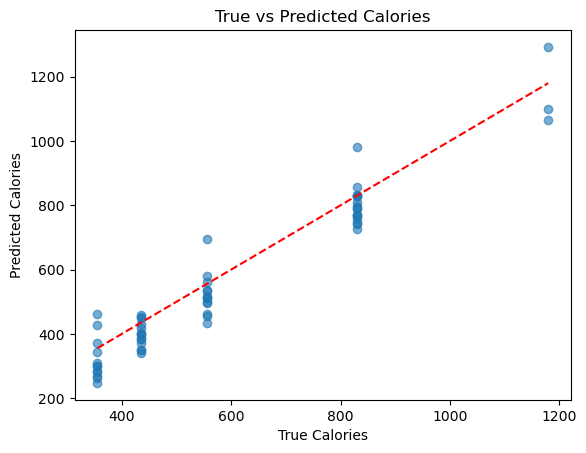

In [16]:
model.load_state_dict(torch.load('best_model.pth'))  # Load best model
model.eval()
predictions, true_values = [], []

with torch.no_grad():
    for lunch_img, breakfast_img, nutrition, labels in test_loader:
        lunch_img, breakfast_img = lunch_img.to(device), breakfast_img.to(device)
        nutrition = nutrition.to(device)
        outputs = model(lunch_img, breakfast_img, nutrition).squeeze()
        predictions.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

r2 = r2_score(true_values, predictions)
print(f"R^2 Score on Test Set: {r2:.4f}")

plt.scatter(true_values, predictions, alpha=0.6)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--')
plt.xlabel("True Calories")
plt.ylabel("Predicted Calories")
plt.title("True vs Predicted Calories")
plt.show()


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmsre = np.sqrt(mse) / np.mean(true_values)
results_df = pd.DataFrame({
    'True Calories': true_values,
    'Predicted Calories': predictions,
    'Difference': np.array(predictions) - np.array(true_values)
})
print("Prediction Results:")
print(results_df)
print("\nError Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Relative Error (RMSRE): {rmsre:.4f}")

Prediction Results:
    True Calories  Predicted Calories  Difference
0           830.0          725.289734 -104.710266
1           830.0          979.930664  149.930664
2           830.0          769.389282  -60.610718
3           355.0          370.404663   15.404663
4           435.0          397.352264  -37.647736
5           355.0          247.232544 -107.767456
6           830.0          787.367065  -42.632935
7           435.0          451.409058   16.409058
8           435.0          370.930267  -64.069733
9           435.0          430.734344   -4.265656
10          435.0          418.724945  -16.275055
11          830.0          770.231201  -59.768799
12          830.0          857.807190   27.807190
13          435.0          383.492065  -51.507935
14          555.0          693.678650  138.678650
15          555.0          460.939819  -94.060181
16          435.0          458.510254   23.510254
17          830.0          792.120850  -37.879150
18          435.0          402